In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist
from sklearn.datasets import fetch_openml

np.random.seed(59)

In [3]:
X_raw = None
y_raw = None
loaded_from = None

try:
    (X_tr, y_tr), (X_te, y_te) = mnist.load_data()
    X_raw = np.concatenate([X_tr, X_te], axis=0)
    y_raw = np.concatenate([y_tr, y_te], axis=0).astype(int)
    loaded_from = "tensorflow.keras.datasets.mnist"
except Exception:
    try:
        mnist_ = fetch_openml("mnist_784", version=1, as_frame=False)
        X_raw = mnist_.data.reshape(-1, 28, 28)
        y_raw = mnist_.target.astype(int)
        loaded_from = "sklearn.fetch_openml('mnist_784')"
    except Exception as e:
        raise RuntimeError(
            "Failed to load MNIST via both TensorFlow and OpenML."
        ) from e

print(f"Loaded MNIST from: {loaded_from}")
print("Raw shapes:", X_raw.shape, y_raw.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Loaded MNIST from: tensorflow.keras.datasets.mnist
Raw shapes: (70000, 28, 28) (70000,)


In [ ]:
X_flat = X_raw.reshape(X_raw.shape[0], -1).astype(np.float32)
X_flat /= 255.0

# Add bias column: X[:, 0] = 1
N, D_no_bias = X_flat.shape
X = np.zeros((N, D_no_bias + 1), dtype=np.float32)
X[:, 0] = 1.0
X[:, 1:] = X_flat

y = y_raw.astype(int)

print(f"X shape (with bias): {X.shape}")
print(f"y shape: {y.shape}, classes: {sorted(np.unique(y))}")

X shape (with bias): (70000, 785)
y shape: (70000,), classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle
)

print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of val samples: {X_val.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")

Number of training samples: 49000
Number of val samples: 14000
Number of test samples: 7000


In [ ]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])


In [16]:
X_train.shape

(49000, 785)

In [ ]:
def sigmoid_func(z):
    return 1 / (1 + np.exp(-z))


def compute_binary_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()


In [ ]:
def compute_multiclass_ova_loss(probs, y_true, n_classes=10):
    """
    Tính Multiclass Loss bằng phương pháp One-vs-All (OvA).

    Args:
        probs (np.array): Ma trận xác suất dự đoán (shape: [m, n_classes]).
                          Đây là output y_hat từ K mô hình Sigmoid.
        y_true (np.array): Vector nhãn thực tế (shape: [m,]).
                           Giá trị là nhãn lớp (0, 1, ..., n_classes-1).
        n_classes (int): Số lượng lớp (K).

    Returns:
        float: Giá trị Loss trung bình của toàn bộ hệ thống OVA.
    """

    # 1. Chuyển đổi nhãn thực tế (y_true) sang định dạng One-Hot Encoding (OHE)
    # Loss của OVA yêu cầu so sánh với ma trận nhị phân (K mô hình)

    # Khởi tạo ma trận OHE (shape: [m, n_classes])
    y_ohe = np.zeros((y_true.size, n_classes))

    # Điền giá trị 1 vào vị trí nhãn đúng
    # np.arange(y_true.size) tạo ra các chỉ số hàng (0, 1, 2, ...)
    y_ohe[np.arange(y_true.size), y_true] = 1

    # 2. Áp dụng np.clip để đảm bảo giá trị xác suất không bị log(0)
    probs = np.clip(probs, 1e-7, 1 - 1e-7)

    # 3. Tính Binary Cross-Entropy (BCE) Loss cho từng cặp (model K, nhãn K)
    # Công thức BCE: -y * log(p) - (1-y) * log(1-p)
    # Vì y_ohe và probs đều là ma trận (m x K), phép tính này được vector hóa
    # và trả về ma trận Loss [m, n_classes].

    loss_matrix = -y_ohe * np.log(probs) - (1 - y_ohe) * np.log(1 - probs)

    # 4. Tính Loss trung bình trên TẤT CẢ các mẫu và TẤT CẢ các lớp (K)
    # Bạn có thể dùng loss_matrix.mean() hoặc tính tổng rồi chia thủ công.
    total = np.sum(loss_matrix)

    return total / (y_true.size * n_classes)

In [ ]:
def predict_ova(X, theta):
    dot_product = np.dot(X, theta.T)
    probs = sigmoid_func(dot_product)
    return probs


def compute_gradient_ova(X, y_true, probs, n_classes=10):
    m = y_true.size
    y_ohe = np.zeros((m, n_classes))
    y_ohe[np.arange(m), y_true] = 1
    error_matrix = probs - y_ohe
    grads = np.dot(X.T, error_matrix) / m

    return grads.T


def update_theta(theta, gradient, lr):
    return theta - lr * gradient


def compute_accuracy_multiclass(X, y_true, theta):
    probs = predict_ova(X, theta)
    y_pred = np.argmax(probs, axis=1)
    return (y_pred == y_true).mean()

In [ ]:
lr = 0.1
epochs = 20
batch_size = 256
n_classes = 10

np.random.seed(random_state)
theta = np.random.uniform(
    low=-0.01, high=0.01, size=(n_classes, X_train.shape[1])
).astype(np.float32)

In [17]:
theta.shape

(10, 785)

In [ ]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

num_train = X_train.shape[0]

for epoch in range(epochs):
    idx = np.arange(num_train)
    np.random.shuffle(idx)
    X_train_shuf = X_train[idx]
    y_train_shuf = y_train[idx]

    batch_losses = []
    for i in range(0, num_train, batch_size):
        Xb = X_train_shuf[i : i + batch_size]
        yb = y_train_shuf[i : i + batch_size]

        # Forward (OvA)
        probs_b = predict_ova(Xb, theta)
        # Loss (macro over K)
        loss_b = compute_multiclass_ova_loss(probs_b, yb, n_classes=n_classes)
        batch_losses.append(loss_b)

        # Backward (OvA)
        grads = compute_gradient_ova(Xb, yb, probs_b, n_classes=n_classes)

        # Update
        theta = update_theta(theta, grads, lr)

    probs_train = predict_ova(X_train, theta)
    train_loss = compute_multiclass_ova_loss(probs_train, y_train, n_classes=n_classes)
    train_acc = compute_accuracy_multiclass(X_train, y_train, theta)

    probs_val = predict_ova(X_val, theta)
    val_loss = compute_multiclass_ova_loss(probs_val, y_val, n_classes=n_classes)
    val_acc = compute_accuracy_multiclass(X_val, y_val, theta)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"EPOCH {epoch + 1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

EPOCH 01 | Train Loss: 0.1246 | Val Loss: 0.1262 | Train Acc: 0.8800 | Val Acc: 0.8779
EPOCH 02 | Train Loss: 0.0960 | Val Loss: 0.0985 | Train Acc: 0.8932 | Val Acc: 0.8881
EPOCH 03 | Train Loss: 0.0852 | Val Loss: 0.0883 | Train Acc: 0.8999 | Val Acc: 0.8938
EPOCH 04 | Train Loss: 0.0796 | Val Loss: 0.0828 | Train Acc: 0.9039 | Val Acc: 0.8981
EPOCH 05 | Train Loss: 0.0757 | Val Loss: 0.0791 | Train Acc: 0.9079 | Val Acc: 0.9007
EPOCH 06 | Train Loss: 0.0731 | Val Loss: 0.0767 | Train Acc: 0.9087 | Val Acc: 0.9017
EPOCH 07 | Train Loss: 0.0711 | Val Loss: 0.0750 | Train Acc: 0.9104 | Val Acc: 0.9032
EPOCH 08 | Train Loss: 0.0696 | Val Loss: 0.0739 | Train Acc: 0.9132 | Val Acc: 0.9033
EPOCH 09 | Train Loss: 0.0682 | Val Loss: 0.0727 | Train Acc: 0.9142 | Val Acc: 0.9053
EPOCH 10 | Train Loss: 0.0673 | Val Loss: 0.0722 | Train Acc: 0.9154 | Val Acc: 0.9059
EPOCH 11 | Train Loss: 0.0666 | Val Loss: 0.0714 | Train Acc: 0.9155 | Val Acc: 0.9065
EPOCH 12 | Train Loss: 0.0658 | Val Loss: 0

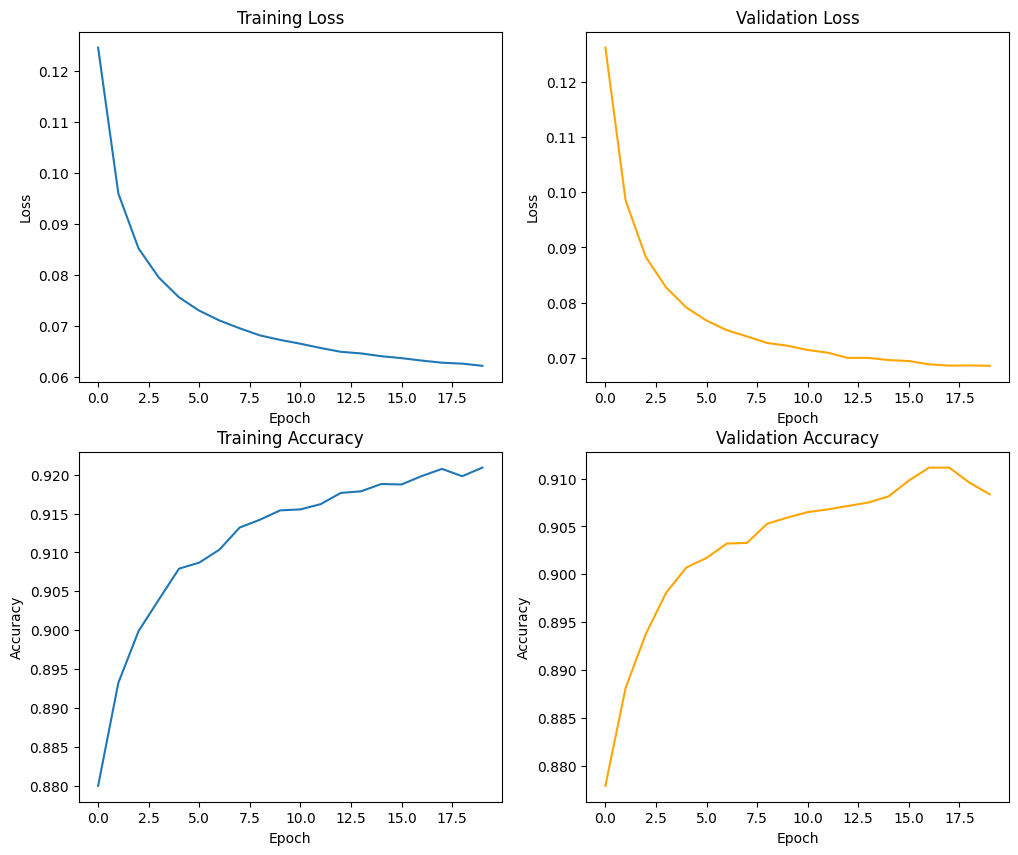

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, "orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Validation Loss")

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs, "orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Validation Accuracy")

plt.show()

In [ ]:
# Val set
val_acc = compute_accuracy_multiclass(X_val, y_val, theta)
print("Evaluation on validation set:")
print(f"Accuracy: {val_acc:.4f}")

Evaluation on validation set:
Accuracy: 0.9084


In [ ]:
# Test set
test_acc = compute_accuracy_multiclass(X_test, y_test, theta)
print("Evaluation on test set:")
print(f"Accuracy: {test_acc:.4f}")

Evaluation on test set:
Accuracy: 0.9080
